# Estimate $k_F$ and $k_M$

## 1. Set up the notebook

Do imports.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ae483tools import *

## 2. Define constants

Define the acceleration of gravity in $\text{kg}\cdot\text{m} \;/\; \text{s}^2$:

In [2]:
g = 9.81

Define the mass of the drone in $\text{kg}$:

In [3]:
m = 34.00/1000 # <-- FIXME

Define the principle moment of inertia about the $z$ axis in $\text{kg}\cdot\text{m}^2$:

In [4]:
# J_z = 2.21e-05 # <-- FIXME
J_z = 2.5667e-5

Using a ruler, measure the distance $\ell$ in **meters** along both the $x_B$ and $y_B$ axis from the center of mass to the center of each rotor. The position of the front-right rotor, for example, would then be expressed in the coordinates of the body-frame as

$$p^B_1 = \begin{bmatrix} \ell \\ -\ell \\ 0 \end{bmatrix}.$$

In [5]:
l = (72.52/2-3.5)/1000 # <-- FIXME

## 3. Find the force parameter

### 3.1 Describe the flight

**Modify the text in this cell** to give a precise description of the flight trajectory, both in words and with the relevant code from `flight.py` (i.e., the sequence of stop and move commands). Please include code in markdown with a "code block" that is delimited by three backslashes above and below — for example, this...

``````
```python
drone_client.move(0.0, 0.0, 0.5, 0.0, 1.0)
```
``````
...is rendered like this:
```python
drone_client.move(0.0, 0.0, 0.5, 0.0, 1.0)
```

### 3.2 Get and plot flight data

Load and resample data.

In [21]:
# Load data
raw_data_drone, raw_data_mocap = load_hardware_data('force_data.json')

# Resample data
data_drone = resample_data_drone(
    raw_data_drone,
    t_min_offset=3.5,    # <-- FIXME
    t_max_offset=2.5,    # <-- FIXME
)

Parse data to get:
* time
* the accelerometer measurements (**note!** these are in units of "$g$'s")
* the motor power commands

In [22]:
t = data_drone['time']
a_x = g * data_drone['acc.x']
a_y = g * data_drone['acc.y']
a_z = g * data_drone['acc.z']
m_1 = data_drone['motor.m1']
m_2 = data_drone['motor.m2']
m_3 = data_drone['motor.m3']
m_4 = data_drone['motor.m4']

Plot accelerometer measurements and motor power commands, and check three things:
* Check that the $x$ and $y$ accelerometer measurements are much smaller than the $z$ accelerometer measurements. We would expect this to be true, because the rotors generate force only in the body-fixed $z$ direction. If this is not true, then something is wrong — fix the problem before going any further.
* Check that all four motor power commands are approximately the same. If this is not true, then either the mass on your drone is unbalanced (e.g., the battery may be out of place) or some of the motors (or rotors) on your drone may be damaged — fix the problem before going any further.
* Check that you are only seeing data from when the drone was *actually flying*. If this is not true, go back and adjust `t_min_offset` and `t_max_offset`.

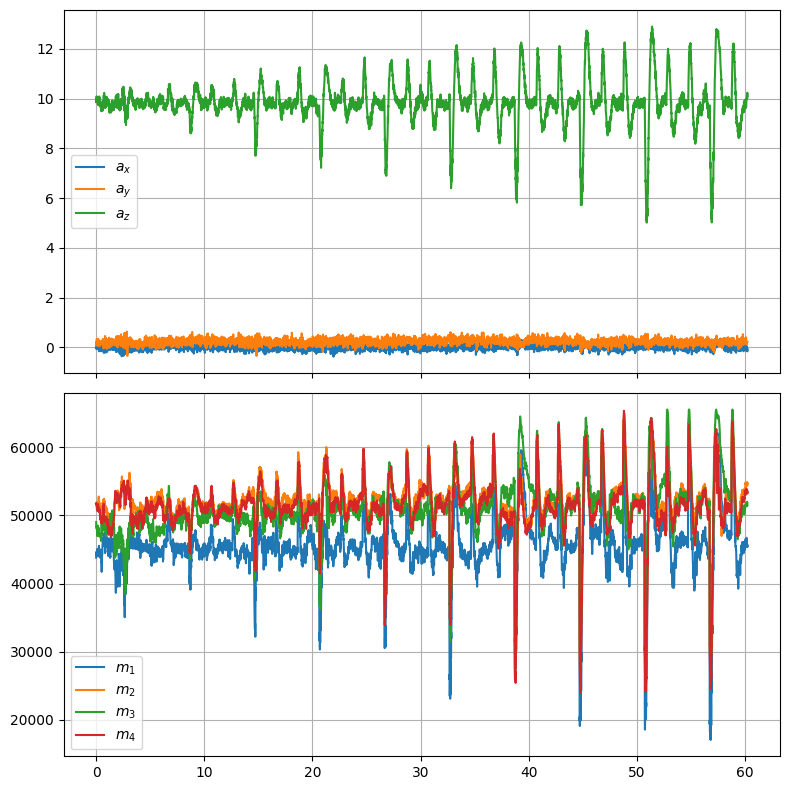

In [23]:
fig, (ax_a, ax_m) = plt.subplots(2, 1, figsize=(8, 8), sharex=True, tight_layout=True)
ax_a.plot(t, a_x, label=r'$a_x$')
ax_a.plot(t, a_y, label=r'$a_y$')
ax_a.plot(t, a_z, label=r'$a_z$')
ax_a.legend()
ax_a.grid()
ax_m.plot(t, m_1, label=r'$m_1$')
ax_m.plot(t, m_2, label=r'$m_2$')
ax_m.plot(t, m_3, label=r'$m_3$')
ax_m.plot(t, m_4, label=r'$m_4$')
ax_m.legend()
ax_m.grid()

### 3.3 Apply linear regression to estimate $k_F$ and $T_F$

Write a function to estimate $k_F$ for a given $T_F$.

In [ ]:
def estimate_force_parameter(T_F):
    # Compute x(t)
    x = np.zeros_like(t) # <-- FIXME
    
    # Compute y(t)
    y = np.zeros_like(t) # <-- FIXME

    # Compute y(t + T_F)
    y = np.interp(t + T_F, t, y)

    # Compute estimate
    k_F = 0. # <-- FIXME

    # Compute RMSE
    RMSE = np.sqrt(np.mean((y - k_F * x)**2))

    return k_F, RMSE, x, y

Find the RMSE for a range of $T_F$.

In [ ]:
# Create an array with a range of T_F's
T_Fs = np.linspace(0., 0.2, 401)

# Create an array to hold the RMSE for each T_F
RMSEs = np.empty_like(T_Fs)

# Find the RMSE for each T_F
for i, T_F in enumerate(T_Fs):
    k_F, RMSEs[i], x, y = estimate_force_parameter(T_F)

Find the value of $T_F$ that gives the minimum RMSE.

In [ ]:
# Find the index of the minimum RMSE
i = 0           # <-- FIXME

# Find the minimum RMSE
RMSE = 0.       # <-- FIXME

# Find the time shift that gives the minimum RMSE
T_F = 0.    # <-- FIXME

Plot the RMSE for a range of $T_F$, showing the minimum.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), tight_layout=True)
ax.plot(T_Fs, RMSEs)
ax.plot(T_F, RMSE, '.', markersize=12)
ax.grid()

Recompute the estimate of $k_F$ for the value of $T_F$ that results in minimum RMSE.

In [ ]:
k_F, RMSE, x, y = estimate_force_parameter(T_F)

Show the estimate.

In [ ]:
print(f'k_F = {k_F:.2e}')
print(f'T_F = {T_F:.3f}')

### 3.4 Validate your estimate

Show a plot that compares the predicted value of $f_z$ (i.e., $k_F x(t)$) with the measured value of $f_Z$ (i.e., $y(t + T_F)$), both as functions of $t$.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)
ax.plot(t, y, label=r'$f_z$ (measured)')
ax.plot(t, k_F * x, '--', label=r'$f_z$ (predicted)')
ax.legend()
ax.grid()

Show a plot that compares the linear fit (i.e., $k_F x(t)$) to the raw data (i.e., $y(t + T_F)$), both as functions of $x(t)$.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6), tight_layout=True)
ax.plot(x, y, '.', markersize=4, label='raw data')
ax.plot([0, 262140], [k_F * 0, k_F * 262140], label='linear fit')
ax.set_xlim(0, 262140)
ax.set_xlabel('x')
ax.set_ylim(0, 0.5)
ax.set_ylabel('y')
ax.legend()
ax.grid()

## 4. Find the moment parameter

### 4.1 Describe the flight

**Modify the text in this cell** to give a precise description of the flight trajectory, both in words and with the relevant code from `flight.py` (i.e., the sequence of stop and move commands). Please include code in markdown with a "code block" that is delimited by three backslashes above and below — for example, this...

``````
```python
drone_client.move(0.0, 0.0, 0.5, 0.0, 1.0)
```
``````
...is rendered like this:
```python
drone_client.move(0.0, 0.0, 0.5, 0.0, 1.0)
```

### 4.2 Get and plot flight data

Load and resample data.

In [33]:
# Load data
raw_data_drone, raw_data_mocap = load_hardware_data('moment_data.json')

# Resample data
data_drone = resample_data_drone(
    raw_data_drone,
    t_min_offset=3.5,    # <-- FIXME
    t_max_offset=2.5,    # <-- FIXME
)

Parse data to get:
* time
* the gyroscope measurements (**note!** these are in units of degrees / second)
* the motor power commands

In [34]:
t = data_drone['time']
w_x = np.deg2rad(data_drone['gyro.x'])
w_y = np.deg2rad(data_drone['gyro.y'])
w_z = np.deg2rad(data_drone['gyro.z'])
m_1 = data_drone['motor.m1']
m_2 = data_drone['motor.m2']
m_3 = data_drone['motor.m3']
m_4 = data_drone['motor.m4']

Find the time step. It should be `0.01` because data were sampled at 100 Hz. (If it is not, stop and fix the problem.)

In [35]:
dt = t[1] - t[0]
print(f'dt = {dt}')

dt = 0.01


Plot gyroscope measurements and motor power commands, and check two things:
* Check that the $x$ and $y$ gyroscope measurements are much smaller than the $z$ gyroscope measurements. We would expect this to be true, because the drone was near hover during flight (only yawing back and forth). If this is not true, then something is wrong — fix the problem before going any further.
* Check that you are only seeing data from when the drone was *actually flying*. If this is not true, go back and adjust `t_min_offset` and `t_max_offset`.

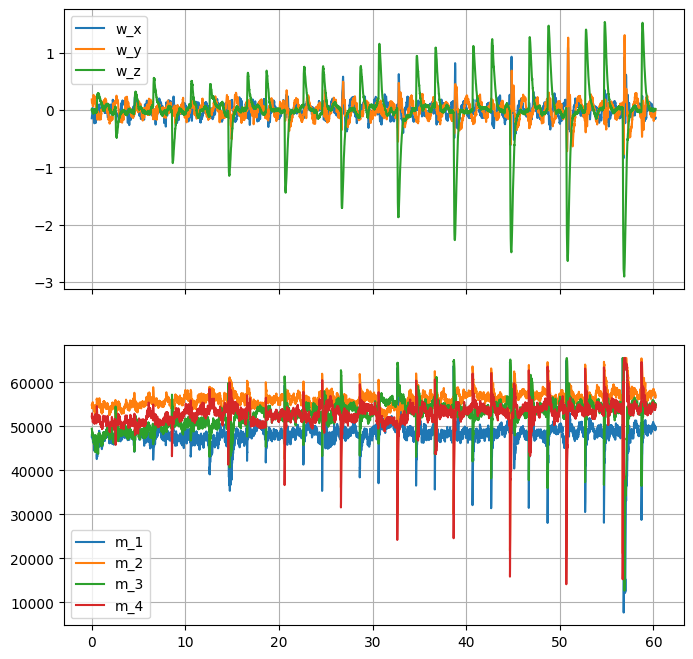

In [36]:
fig, (ax_w, ax_m) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
ax_w.plot(t, w_x, label='w_x')
ax_w.plot(t, w_y, label='w_y')
ax_w.plot(t, w_z, label='w_z')
ax_w.legend()
ax_w.grid()
ax_m.plot(t, m_1, label='m_1')
ax_m.plot(t, m_2, label='m_2')
ax_m.plot(t, m_3, label='m_3')
ax_m.plot(t, m_4, label='m_4')
ax_m.legend()
ax_m.grid()

### 4.3 Use finite difference to estimate $\dot{w}_z$

Estimate $\dot{w}_z$ by finite difference.

In [ ]:
w_z_dot = np.zeros_like(w_z) # <-- FIXME (REPLACE WITH CODE TO COMPUTE W_Z BY FINITE DIFFERENCE)

Truncate all other data so that everything has the same length.

In [ ]:
# FIXME (REPLACE WITH CODE TO MODIFY t, m_1, etc.)

Plot both $w_z$ and $\dot{w}_z$ as a check to make sure finite difference was implemented correctly. (What should the sign of $\dot{w}_z$ be when $w_z$ is increasing, for example?)

In [ ]:
fig, (ax_w_z, ax_w_z_dot) = plt.subplots(2, 1, figsize=(8, 4), sharex=True, tight_layout=True)
ax_w_z.plot(t, w_z, label=r'$w_z$')
ax_w_z.legend()
ax_w_z.grid()
ax_w_z_dot.plot(t, w_z_dot, '--', label=r'$\dot{w}_z$')
ax_w_z_dot.legend()
ax_w_z_dot.grid()

### 4.4 Apply linear regression to estimate $k_M$ and $T_M$

Write a function to estimate $k_M$ for a given $T_M$.

In [ ]:
def estimate_kM(T_M):
    # Compute x(t)
    x = np.zeros_like(t) # <-- FIXME
    
    # Compute y(t)
    y = np.zeros_like(t) # <-- FIXME
    
    # Compute y(t + T_M)
    y = np.interp(t + T_M, t, y)

    # Compute estimate
    k_M = 0. # <-- FIXME
    
    # Compute RMSE
    RMSE = np.sqrt(np.mean((y - k_M * x)**2))

    return k_M, RMSE, x, y

Find the RMSE for a range of $T_M$.

In [ ]:
# Create an array with a range of T's
T_Ms = np.linspace(0., 0.2, 401)

# Create an array to hold the RMSE for each T
RMSEs = np.empty_like(T_Ms)

# Find the RMSE for each T_M
for i, T_M in enumerate(T_Ms):
    k_M, RMSEs[i], x, y = estimate_kM(T_M)

Find the value of $T_M$ that gives the minimum RMSE.

In [ ]:
# Find the index of the minimum RMSE
i = 0           # <-- FIXME

# Find the minimum RMSE
RMSE = 0.       # <-- FIXME

# Find the time shift that gives the minimum RMSE
T_M = 0.        # <-- FIXME

Plot the RMSE for a range of $T_M$, showing the minimum.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3), tight_layout=True)
ax.plot(T_Ms, RMSEs)
ax.plot(T_M, RMSE, '.', markersize=12)
ax.grid()

Recompute the estimate of $k_F$ for the value of $T_M$ that results in minimum RMSE.

In [ ]:
k_M, RMSE, x, y = estimate_kM(T_M)

Show the estimate.

In [ ]:
print(f'k_M = {k_M:.2e}')
print(f'T_M = {T_M:.3f}')

### 4.5 Validate your estimate

Show a plot that compares the predicted value of $\tau_z$ (i.e., $k_M x(t)$) with the measured value of $\tau_Z$ (i.e., $y(t + T_M)$), both as functions of $t$.

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), tight_layout=True)
ax.plot(t, y, label=r'$\tau_z$ (measured)')
ax.plot(t, k_M * x, '--', label=r'$\tau_z$ (predicted)')
ax.legend()
ax.grid()

Show a plot that compares the linear fit (i.e., $k_M x$ versus $x$) to the raw data (i.e., $y(t + T_M)$ versus $x(t)$).

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), tight_layout=True)
ax.plot(x, y, '.', markersize=4, label='raw data')
ax.plot([-131070, 131070], [k_M * -131070, k_M * 131070], label='linear fit')
ax.set_xlim(-131070, 131070)
ax.set_xlabel('x')
ax.set_ylim(-.002, 0.002)
ax.set_ylabel('y')
ax.legend()
ax.grid()

## 5. Summarize and discuss the results

### 5.1 Summary of results

In [ ]:
print(f'l = {l:.3f} m')
print(f'k_F = {k_F:.2e} N  (T_F = {T_F:.3f} s)')
print(f'k_M = {k_M:.2e} N  (T_M = {T_M:.3f} s)')

### 5.2 Conclusions about time delay

**Modify the text in this cell** to answer the following questions about your results:

* What is the delay between the time at which a motor command is given and the time at which the corresponding rotor produces a force along the $z_B$ axis? Do you consider this delay to be significant?
* What is the delay between the time at which a motor command is given and the time at which the corresponding rotor produces a moment about the $z_B$ axis? Do you consider this delay to be significant?

Then, based on your answers to these first two questions, answer four more:

* What delay would you expect between the time at which your controller asks for a net torque $\tau_x$ and the time at which that torque is produced? Do you consider this delay to be significant?
* What delay would you expect between the time at which your controller asks for a net torque $\tau_y$ and the time at which that torque is produced? Do you consider this delay to be significant?
* What delay would you expect between the time at which your controller asks for a net torque $\tau_z$ and the time at which that torque is produced? Do you consider this delay to be significant?
* What delay would you expect between the time at which your controller asks for a net force $f_z$ and the time at which that force is produced? Do you consider this delay to be significant?

Please justify your answers (don't just say "yes" or "no").

### 5.3 Sources of error

**Modify the text in this cell** to discuss possible sources of error. For example:

* How uncertain was each measurement and each computed quantity?
* What assumptions were made and to what extent were these assumptions violated?

You may find that these questions are harder to answer than in the previous lab.

### 5.4 Ways to improve the results

**Modify the text in this cell** to propose at least one way in which the experiments or the analysis could be improved to get estimates of $k_F$ and $k_M$ (as well as $T_F$ and $T_M$) that are more accurate (i.e., less uncertain). You could suggest improvements to your current method of approach, but you are also welcome to suggest a completely different method of approach.

### 5.5 Reflection

**Modify the text in this cell** to describe, in at least two or three sentences, the biggest struggle you had (with the technical material, with collaboration, etc.) and the most important thing that you learned.